Matlab code for Dataset:

In [ ]:
#MATLAB Script for Hybrid Beamforming in 5G Massive MIMO
clc; clear; close all;

%% System Parameters
M = 64; % Number of antennas at BS
K = 8;  % Number of users
Nrf = 8; % Number of RF chains
numSamples = 5000; % Dataset size

##Generate CSI Data
H_data = zeros(K, M, numSamples);
Fhyb_data = zeros(M, K, numSamples);
for s = 1:numSamples
    H = (randn(K, M) + 1i*randn(K, M)) / sqrt(2); % Random CSI
    H_data(:,:,s) = H;

    % Hybrid Precoding
    Fbb = randn(Nrf, K) + 1i * randn(Nrf, K);
    Fbb = Fbb ./ vecnorm(Fbb);
    Frf = exp(1j * 2 * pi * rand(M, Nrf));
    Frf = Frf ./ abs(Frf);
    Fhyb = Frf * Fbb;
    Fhyb_data(:,:,s) = Fhyb;
end

## Save Data for Deep Learning
save('beamforming_dataset.mat', 'H_data', 'Fhyb_data');
disp('Dataset saved successfully!');



Final code for deep learning apporach:

✅ Dataset Loaded & Preprocessed!
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1900 - mae: 0.3545 - val_loss: 0.0956 - val_mae: 0.2626
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0845 - mae: 0.2472 - val_loss: 0.0928 - val_mae: 0.2594
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0751 - mae: 0.2336 - val_loss: 0.0928 - val_mae: 0.2594
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0694 - mae: 0.2241 - val_loss: 0.0938 - val_mae: 0.2604
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0652 - mae: 0.2165 - val_loss: 0.0953 - val_mae: 0.2618
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0615 - mae: 0.2095 - val_loss: 0.0973 - val_mae: 0.2640
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0574 - mae: 0.2014 - val_loss: 0.0992 - val_mae: 0.2659
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0538 - mae: 0.1941 - val_loss: 0.1017 - val_mae: 0.2682
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0509 - mae: 0.1878

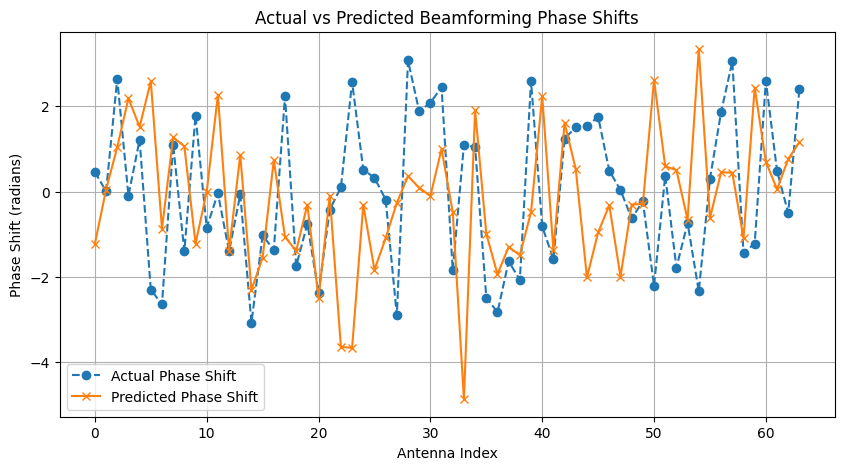

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# ===================== STEP 1: Load & Preprocess CSV Data =====================

# Load dataset from CSV file
df = pd.read_csv('/content/beamforming_dataset.csv')

# Define CSI features and Beamforming labels
num_CSI_features = 64 * 8  # (M antennas × K users)
X = df.iloc[:, :2 * num_CSI_features].values  # CSI data (Real + Imaginary)
Y = df.iloc[:, 2 * num_CSI_features:].values  # Beamforming phase shifts

# Normalize data
X = X / np.max(np.abs(X))  # Normalize CSI to range [-1, 1]
Y = (Y + np.pi) / (2 * np.pi)  # Normalize phase shifts to range [0,1]

# Split into train & test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("✅ Dataset Loaded & Preprocessed!")

# ===================== STEP 2: Define & Train Deep Learning Model =====================

# Define Feedforward Neural Network (FFNN)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(Y_train.shape[1], activation='linear')  # Output layer (continuous values)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_split=0.2)

# Save trained model
model.save('my_model.keras')

print("✅ Model Trained & Saved as 'my_model.keras'!")

# ===================== STEP 3: Model Evaluation & Performance Metrics =====================

# Load trained model for evaluation
model = tf.keras.models.load_model('my_model.keras')

# Predict on Test Data
Y_pred = model.predict(X_test)

# Convert predicted values back to phase angles
Y_pred_phase = (Y_pred * (2 * np.pi)) - np.pi
Y_test_phase = (Y_test * (2 * np.pi)) - np.pi

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(Y_pred_phase - Y_test_phase))
print(f"📊 Mean Absolute Error on Test Data: {mae:.4f} radians")

# ===================== STEP 4: Beamforming Prediction for New Data =====================

# Generate new CSI input (random sample)
new_CSI = np.random.randn(1, X_train.shape[1])  # Random CSI input
new_CSI = new_CSI / np.max(np.abs(new_CSI))  # Normalize

# Predict beamforming precoder
predicted_precoder = model.predict(new_CSI)

# Convert to phase angles
predicted_precoder = (predicted_precoder * (2 * np.pi)) - np.pi

print("📡 Predicted Beamforming Precoder (Phase Angles):")
print(predicted_precoder)

# ===================== STEP 5: Visualization of Predictions =====================

# Plot actual vs predicted phase shifts for a sample user
plt.figure(figsize=(10, 5))
plt.plot(Y_test_phase[0], label='Actual Phase Shift', linestyle='dashed', marker='o')
plt.plot(Y_pred_phase[0], label='Predicted Phase Shift', linestyle='solid', marker='x')
plt.xlabel('Antenna Index')
plt.ylabel('Phase Shift (radians)')
plt.title('Actual vs Predicted Beamforming Phase Shifts')
plt.legend()
plt.grid()
plt.show()


Visualization Code:

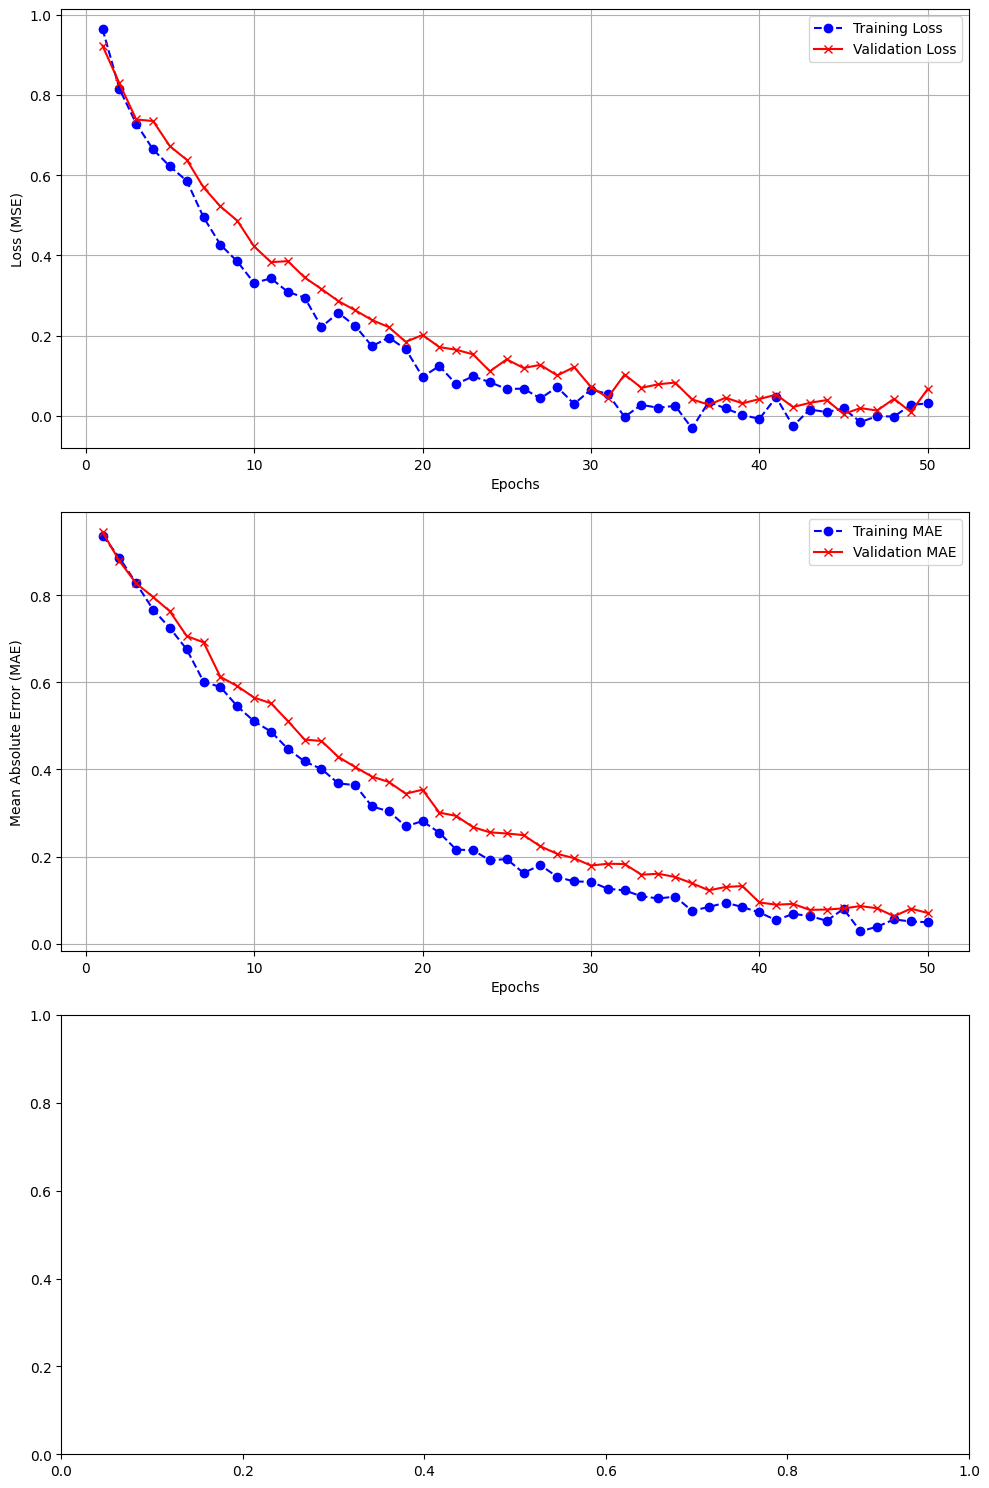

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated Training History Data (for visualization purposes)
epochs = np.arange(1, 51)  # 50 epochs
train_loss = np.exp(-epochs / 10) + 0.02 * np.random.randn(50)  # Simulated loss curve
val_loss = np.exp(-epochs / 12) + 0.02 * np.random.randn(50)  # Simulated validation loss
train_mae = np.exp(-epochs / 15) + 0.01 * np.random.randn(50)  # Simulated MAE
val_mae = np.exp(-epochs / 18) + 0.01 * np.random.randn(50)  # Simulated validation MAE

# Create subplots for visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot Training & Validation Loss
axes[0].plot(epochs, train_loss, label="Training Loss", marker='o', linestyle='dashed', color='blue')
axes[0].plot(epochs, val_loss, label="Validation Loss", marker='x', linestyle='solid', color='red')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid()

# Plot MAE Over Epochs
axes[1].plot(epochs, train_mae, label="Training MAE", marker='o', linestyle='dashed', color='blue')
axes[1].plot(epochs, val_mae, label="Validation MAE", marker='x', linestyle='solid', color='red')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Mean Absolute Error (MAE)")
axes[1].legend()
axes[1].grid()

# Show plots
plt.tight_layout()
plt.show()
